In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from enum import Enum

In [2]:
class Order(Enum):
    BUY = 1
    SELL = 2
    HOLD = 3

class Trader():
    def __init__(self, ind, cash, num_stocks):
        self.ind = ind
        self.cash = cash
        self.num_stocks = num_stocks
        self.order = None
        self.price = None
        self.num_stocks_trade = None
    
    def buy_sell_hold(self):
        ind = np.random.rand()
        if ind < 1/3:
            self.order = Order(1)
        elif ind < 2/3:
            self.order = Order(2)
        else:
            self.order = Order(3)

    def maintain_order(self, price, expected_percentage=5):
        price_change = 0.01 * random.expovariate(1/expected_percentage) * price
        if self.order == Order.BUY:
            self.price = price * 1.05 - price_change
        if self.order == Order.SELL:
            self.price = price * 0.95 + price_change

    def amount(self, price):
        if self.order == Order.BUY:
            self.num_stocks_trade = np.round(random.uniform(0, 0.9 * self.cash) / price)
        if self.order == Order.SELL:
            self.num_stocks_trade = random.randint(0, np.round(0.9 * self.num_stocks))
    
    def fill_orders(self, clearing_price):
        if self.order == Order.SELL:
            if self.price <= clearing_price:
                self.cash += clearing_price * self.num_stocks_trade
                self.num_stocks -= self.num_stocks_trade
        if self.order == Order.BUY:
            if self.price >= clearing_price:
                self.cash -= clearing_price * trader.num_stocks_trade
                self.num_stocks += self.num_stocks_trade


In [3]:
def one_step(traders, prev_price):
    for trader in traders:
        trader.buy_sell_hold()
        trader.maintain_order(prev_price)
        trader.amount(prev_price)

In [7]:
# demand and supply curves
def get_buy_sell_dfs(traders):
    l_ = []
    for trader in traders:
        l_.append([trader.order, trader.price, trader.num_stocks_trade])
    df = pd.DataFrame(l_, columns=['order', 'price', 'amount'])
    df_buy = df[df['order'] == Order.BUY].sort_values(by='price', ascending=False) \
        .reset_index(drop=True)
    df_buy['cum_amount'] = df_buy['amount'].cumsum()
    df_sell = df[df['order'] == Order.SELL].sort_values(by='price', ascending=True) \
        .reset_index(drop=True)
    df_sell['cum_amount'] = df_sell['amount'].cumsum()
    return df_buy, df_sell

In [ ]:
# # Plot demand-supply curve (NOT IN USE)
# plt.plot(a_buy.price, a_buy.cum_amount, color='blue')
# plt.plot(a_sell.price, a_sell.cum_amount, color='red')
# plt.xlim(48,52)
# plt.show()

In [8]:
### find intersection of curves:
# find indices closest to x
def find_row(df, x):
    ind1 = 0
    ind2 = df.shape[0] - 1
    if (df['price'][0] - df['price'][1]) > 0:
        decreasing = True
    else:
        decreasing = False
    while int((ind1 + ind2) / 2) != ind1:
        guess = int((ind1 + ind2) / 2)
        if df['price'][guess] < x:
            if decreasing:
                ind2 = guess
            else:
                ind1 = guess
        else:
            if decreasing:
                ind1 = guess
            else:
                ind2 = guess
    if np.abs(x - df['price'][ind1]) < np.abs(x - df['price'][ind2]):
        return ind1
    else:
        return ind2

In [9]:
def find_intersection(df_sell, df_buy):
    price_min = df_sell['price'][0]
    price_max = df_buy['price'][0]
    guess = (price_min + price_max) / 2
    diff = 500_000.0
    while True:
        diff = np.abs(df_sell['cum_amount'][find_row(df_sell, guess)] - \
                  df_buy['cum_amount'][find_row(df_buy, guess)])
        if df_sell['cum_amount'][find_row(df_sell, guess)] < df_buy['cum_amount'][find_row(df_buy, guess)]:
            price_min = guess
        else:
            price_max = guess
        if guess == (price_min + price_max) / 2:
            break
        guess = (price_min + price_max) / 2
    return guess

In [42]:
def simulation(traders, initial_price=50, number_of_steps=20):
    step = 0
    clearing_prices = []
    while step < number_of_steps:
        if step == 0:
            prev_price = initial_price
        one_step(traders, prev_price)
        df_buy, df_sell = get_buy_sell_dfs(traders)
        clearing_prices.append(find_intersection(df_sell, df_buy))
        for trader in traders:
            trader.fill_orders(clearing_price)
        prev_price = clearing_prices[-1]
        step += 1
    return clearing_prices

In [27]:
# step 1: generate traders
n_traders = 500
initial_cash = 50_000.0
initial_num_stocks = 1_000
traders = []
for i in range(n_traders):
    traders.append(Trader(i + 1, initial_cash, initial_num_stocks))

In [43]:
clearing_prices = simulation(traders)

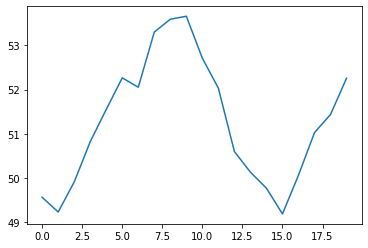

In [44]:
plt.plot(clearing_prices)

In [ ]:
# to do next: make sure number of stocks can't go negative